In [78]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json
import scipy.stats as st
%matplotlib inline
plt.rcParams.update({'font.size': 12})
# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [79]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [80]:
DA_dir = Path.cwd() / "models"
noDA_dir = Path.cwd().parent / "FinalPaperMVEnoDAv2" / "models"
lets = list("abcde".upper())
DA_paths = [DA_dir / ("Run" + i + "_snll") for i in lets]
noDA_paths = [noDA_dir / ("Run" + i + "_noDA_snll") for i in lets]

In [105]:
def get_models(paths):
    mods = []
    stats = []
    for mod_path in paths:
        mod_json = mod_path.parent / (mod_path.name + ".json")
        model = NeuralNetworkMVEv3(npix=40).cuda()
        model.load_state_dict(torch.load(mod_path)['state_dict'])
        stats.append(json.load(open(mod_json, 'r')))
        mods.append(model)

        
    return mods, stats

def get_test_predictions(model, test_dataloader):
    all_mean = []
    all_var = []
    all_truth = []
    
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.float()
            
            pred, _ = model(X.cuda())
            mean = list(pred[:, 0].cpu().numpy())
            var = list(pred[:, 1].cpu().numpy())
            truth = list(y.cpu().numpy())

            all_mean = all_mean + mean
            all_var = all_var + var
            all_truth = all_truth + truth

    return np.array(all_mean), np.array(all_var), np.array(all_truth)

def evaluate_nll(mean, var, truth):
    var = torch.tensor(var)
    nll = float(loss_bnll(mean, var, truth, beta = 0.0))
    return nll

def evaluate_r2(mean, truth):
    return r2_score(truth, mean)


def calculate_coverage(mean, var, truth):
    """
    Calculates the fraction of images with correct prediction within each confidence level (0% - 100%).
    This assumes the variance is based on a gaussian distribution.
    
    E.g. In 100 lenses, if 30 lenses have predictions within a 50% confidence interval, the point
    (50, 30) will be present.

    At 0%, no lenses should be in the confidence interval. 
    At 100%, all lenses should be in the confidence interval.
    """

    # Convert variance to standard deviation
    sig = np.sqrt(var)

    # Calculate zscore = (x - mu) / sig, and take absolute value, e.g. 1.96
    zscore = np.abs((mean - truth) / sig)

    # Calculate the fraction of gaussian within zscore sigma for two-tailed gaussian
    one_tail_cl = st.norm.cdf(zscore) # e.g. cdf(1.96) = 0.975 = 97.5% of gaussian
    two_tail_cl = 1 - ((1 - one_tail_cl) * 2) # total gaussian - ((excluded 2.5% of gaussian) * 2)

    # Above (two_tail_cl)% confidence, image will be excluded from correct prediction
    # Equivalently, we can sort the array against the fraction of lenses
    confidence_level = np.sort(two_tail_cl)
    image_fraction = np.arange(len(two_tail_cl)) / len(two_tail_cl)

    return confidence_level, image_fraction

In [150]:
DA_models, DA_stats = get_models(DA_paths)
noDA_models, noDA_stats = get_models(noDA_paths)
lDA = range(len(DA_models))
lnoDA = range(len(noDA_models))

In [148]:
mvt_DA_source = np.array([get_test_predictions(DA_models[i], source_test_dataloader) for i in lDA])
mvt_DA_target = np.array([get_test_predictions(DA_models[i], target_test_dataloader) for i in lDA])
mvt_noDA_source = np.array([get_test_predictions(noDA_models[i], source_test_dataloader) for i in lnoDA])
mvt_noDA_target = np.array([get_test_predictions(noDA_models[i], target_test_dataloader) for i in lnoDA])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (268967666.py, line 1)

In [138]:
nll_DA_source = np.array([evaluate_nll(mvt_DA_source[i, 0], mvt_DA_source[i, 1], mvt_DA_source[i, 2]) for i in lDA])
nll_DA_target = np.array([evaluate_nll(mvt_DA_target[i, 0], mvt_DA_target[i, 1], mvt_DA_target[i, 2]) for i in lDA])
nll_noDA_source = np.array([evaluate_nll(mvt_noDA_source[i, 0], mvt_noDA_source[i, 1], mvt_noDA_source[i, 2]) for i in lnoDA])
nll_noDA_target = np.array([evaluate_nll(mvt_noDA_target[i, 0], mvt_noDA_target[i, 1], mvt_noDA_target[i, 2]) for i in lnoDA])

In [139]:
r2_DA_source = np.array([evaluate_r2(mvt_DA_source[i, 0], mvt_DA_source[i, 2]) for i in lDA])
r2_DA_target = np.array([evaluate_r2(mvt_DA_target[i, 0], mvt_DA_target[i, 2]) for i in lDA])
r2_noDA_source = np.array([evaluate_r2(mvt_noDA_source[i, 0], mvt_noDA_source[i, 2]) for i in lnoDA])
r2_noDA_target = np.array([evaluate_r2(mvt_noDA_target[i, 0], mvt_noDA_target[i, 2]) for i in lnoDA])

In [151]:
cc_DA_source = np.array([calculate_coverage(mvt_DA_source[i, 0], mvt_DA_source[i, 1], mvt_DA_source[i, 2]) for i in lDA])
cc_DA_target = np.array([calculate_coverage(mvt_DA_target[i, 0], mvt_DA_target[i, 1], mvt_DA_target[i, 2]) for i in lDA])
cc_noDA_source = np.array([calculate_coverage(mvt_noDA_source[i, 0], mvt_noDA_source[i, 1], mvt_noDA_source[i, 2]) for i in lnoDA])
cc_noDA_target = np.array([calculate_coverage(mvt_noDA_target[i, 0], mvt_noDA_target[i, 1], mvt_noDA_target[i, 2]) for i in lnoDA])

/tmp/ipykernel_7925/3986409936.py:59: RuntimeWarning: divide by zero encountered in divide
  zscore = np.abs((mean - truth) / sig)


In [145]:
def print_score(name, vals):
    print(name + ":", np.median(vals).round(4), "+-", vals.std().round(4))

In [146]:
print_score("R2 DA Source", r2_DA_source)
print_score("R2 DA Target", r2_DA_target)
print_score("R2 noDA Source", r2_noDA_source)
print_score("R2 noDA Target", r2_noDA_target)

R2 DA Source: 0.9917 +- 0.0018
R2 DA Target: 0.986 +- 0.0025
R2 noDA Source: 0.9986 +- 0.0003
R2 noDA Target: 0.9727 +- 0.0206


In [147]:
print_score("NLL DA Source", nll_DA_source)
print_score("NLL DA Target", nll_DA_target)
print_score("NLL noDA Source", nll_noDA_source)
print_score("NLL noDA Target", nll_noDA_target)

NLL DA Source: -2.4338 +- 0.1427
NLL DA Target: -2.2837 +- 0.1243
NLL noDA Source: -3.3604 +- 0.1305
NLL noDA Target: 4.6363 +- 6539.4112


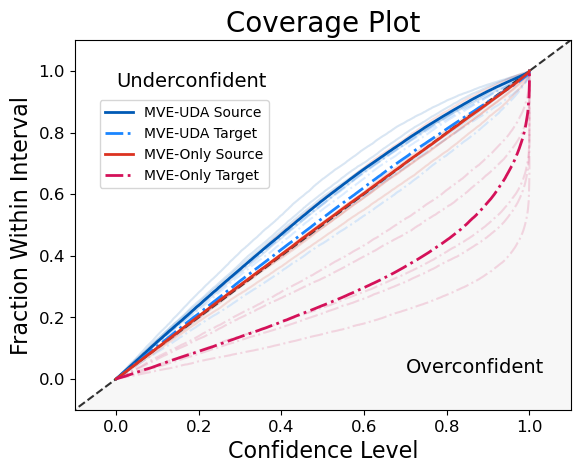

In [196]:
plt.title("Coverage Plot", fontsize = 20)
plt.xlabel("Confidence Level", fontsize = 16)
plt.ylabel("Fraction Within Interval", fontsize = 16)
plt.annotate("Underconfident", xy = (0, 0.95), fontsize = 14)
plt.annotate("Overconfident", xy = (0.7, 0.02), fontsize = 14)

plt.fill_between([-1, 2], [-1, 2], y2 = -10, alpha = 0.03, color = 'k')
plt.plot([-1, 2], [-1, 2], color = "k", ls = "--", alpha = 0.8)

for mod in lDA:
    plt.plot(cc_DA_source[mod, 0], cc_DA_source[mod, 1], color = '#005AB5', alpha = 0.15) 
    plt.plot(cc_DA_target[mod, 0], cc_DA_target[mod, 1], color = '#1A85FF', alpha = 0.15, ls = "-.") 

for mod in lnoDA:
    plt.plot(cc_noDA_source[mod, 0], cc_noDA_source[mod, 1], color = '#DC3220', alpha = 0.15) 
    plt.plot(cc_noDA_target[mod, 0], cc_noDA_target[mod, 1], color = '#D41159', alpha = 0.15, ls = "-.") 
    
plt.plot(cc_DA_source[:, 0].mean(axis = 0), cc_DA_source[mod, 1], lw = 2, label = "MVE-UDA Source", color = '#005AB5')
plt.plot(cc_DA_target[:, 0].mean(axis = 0), cc_DA_target[mod, 1], lw = 2, label = "MVE-UDA Target", color = '#1A85FF', ls = "-.")
plt.plot(cc_noDA_source[:, 0].mean(axis = 0), cc_noDA_source[mod, 1], lw = 2, label = "MVE-Only Source", color = '#DC3220')
plt.plot(cc_noDA_target[:, 0].mean(axis = 0), cc_noDA_target[mod, 1], lw = 2, label = "MVE-Only Target", color = '#D41159',ls = "-.") 


plt.legend(fontsize = 10, loc = (0.05, 0.6))
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.savefig("figures/coverage.png", bbox_inches = 'tight', dpi = 400)

array([5.32319419e-05, 7.06700658e-05, 8.26937984e-05, ...,
       9.99989620e-01, 9.99999405e-01, 9.99999994e-01])

In [ ]:
# Isomap

axlim = 5
cx = -8
cy = 3
n = 500
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5),)
s = ax1.scatter(trained_source_iso[:, 0][:n], trained_source_iso[:, 1][:n], s=150, marker='2', alpha = 0.8, c = isomap_source_label_sample[:n], 
           label = "Source")
ax1.scatter(trained_target_iso[:, 0][:n], trained_target_iso[:, 1][:n], s=150, marker='.', alpha = 0.5, c = isomap_target_label_sample[:n],
           label = "Target")
ax1.set_xlim(-axlim + cx, axlim + cx)
ax1.set_ylim(-axlim + cy, axlim + cy)
ax1.set_title('MVE-UDA', fontsize = 25)

# Remove axis ticks and labels
# xl, xr = ax1.get_xlim()
# yl, yr = ax1.get_ylim()
# xt = np.int32(np.linspace(xl, xr, 5))
# yt = np.int32(np.linspace(yl, yr, 5))

# ax1.set_xticks(xt)
# ax1.set_yticks(yt)
# ax1.set_xticklabels(xt)
# ax1.set_yticklabels(yt)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.legend(fontsize = 15)
cbar = plt.colorbar(s, ax = ax1)
cbar.set_label("$\\theta_E$ (\")",size=18)
cbar.ax.tick_params(labelsize=12) #.set_label(label = "$\\theta_E$ (\")", labelsize=18)
plt.savefig("post_isomap_da.png", bbox_inches = 'tight', dpi = 400)